In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

seed = 47

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

In [155]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [159]:
big = train

big.species = big.species.astype('category')
big.species = big.species.cat.codes

# big = pd.get_dummies(big, sparse=True)

big.species

0       3
1      49
2      65
3      94
4      84
5      40
6      54
7      78
8      53
9      89
10     98
11     16
12     74
13     50
14     58
15     31
16     43
17      4
18     75
19     44
20     83
21     84
22     13
23     66
24     15
25      6
26     73
27     22
28     73
29     31
       ..
960    85
961    89
962    94
963    45
964    48
965    86
966    81
967    14
968     4
969    77
970    56
971    82
972     2
973    85
974    70
975    88
976     0
977    75
978    14
979    86
980    81
981    97
982    70
983    72
984    34
985    40
986     5
987    11
988    78
989    50
Name: species, dtype: int8

In [170]:
def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [171]:
def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [234]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score, brier_score_loss, log_loss
from sklearn.pipeline import Pipeline

classifiers = {
        "LR": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1) },
        "LR_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
        "RF_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) }
}  

classifiers = {
    "LR_std": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
}   

measures = {
    'pre': precision_score,
    #'avg': average_precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score,
    #'ll': log_loss,
    #'br': brier_score_loss
}

In [243]:
def test_split(test_size):
    sss = StratifiedShuffleSplit(10, test_size=test_size, random_state=seed)
    
    for clf in classifiers.keys(): 
        c = classifiers[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        #print(np.asarray(y_test))
        
        #print(y_test)

        for clf in classifiers.keys():                    
            c = classifiers[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = c["f"].predict(X_test)
            #print(clf)
            #print(classification_report(y_test, y_pred))
            #print(y_test)
            #print(y_pred)

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc' and meas != 'br'):
                    c[meas].append(m(y_test, y_pred, average='micro'))
                elif (meas == 'll'):
                    c[meas].append(m(y_test, y_pred, labels=y_test))
                else:
                    c[meas].append(m(y_test, y_pred))
    
    return classifiers
               
cl = []
    
for i in range(1,9):
    cl.append(test_split(0.1 + 0.1 * i))
#cl.append(test_split(0.3))

In [244]:
cl

#results

[{'LR_std': {'acc': [0.86083052749719413,
    0.84287317620650959,
    0.856341189674523,
    0.85970819304152635,
    0.88103254769921435,
    0.86531986531986527,
    0.856341189674523,
    0.85521885521885521,
    0.85409652076318743,
    0.86531986531986527],
   'ck': [0.85941043083900226,
    0.84126984126984128,
    0.85487528344671204,
    0.85827664399092973,
    0.8798185941043084,
    0.86394557823129248,
    0.85487528344671204,
    0.8537414965986394,
    0.85260770975056688,
    0.86394557823129248],
   'f': Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='multinomial',
             n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False))]),
   'f1': [0.86083052749719413,
    0.84287317620650959,
    0.856341189674523,
    0.8597

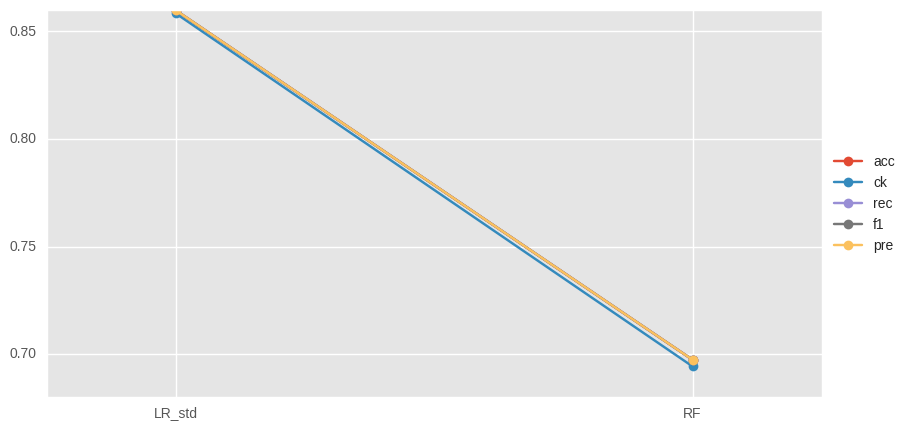

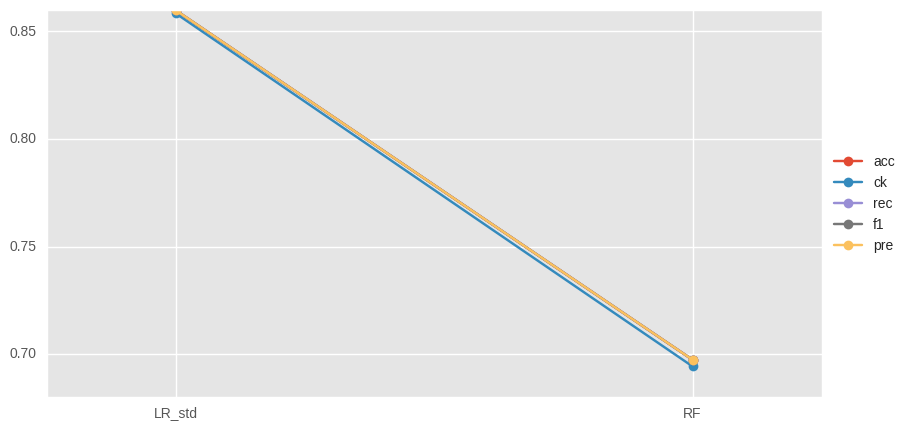

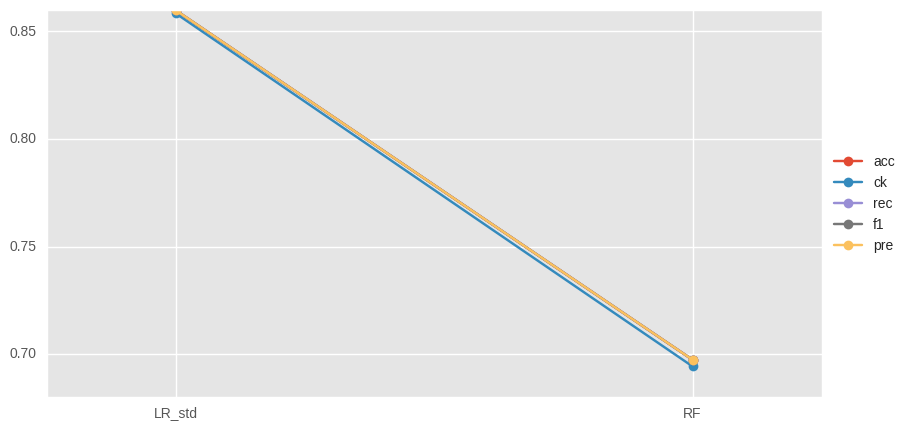

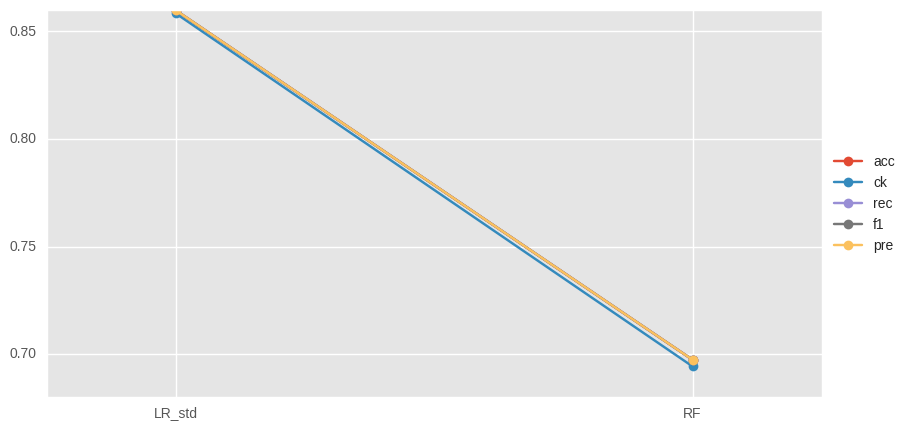

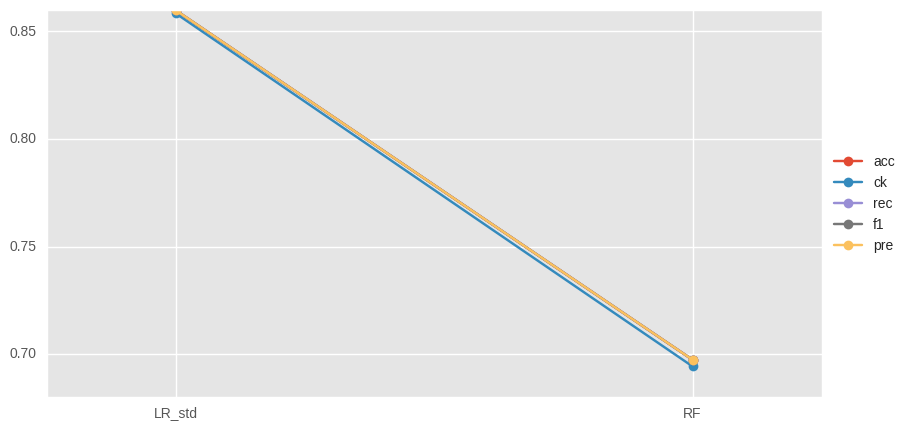

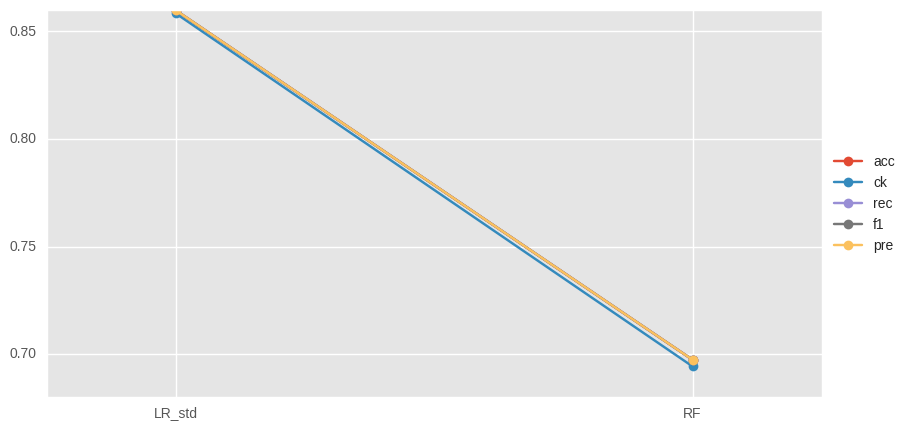

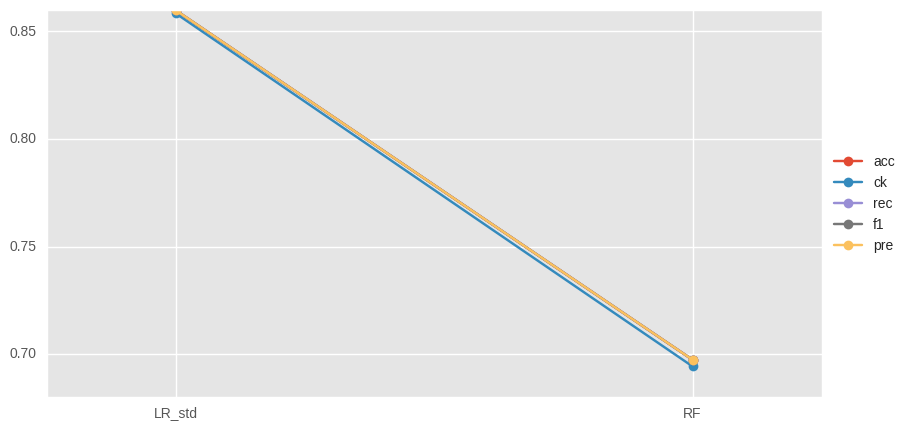

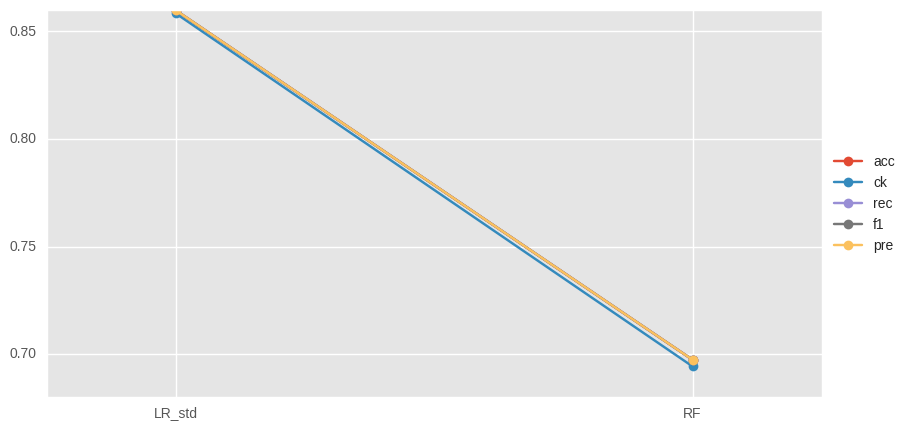

In [245]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(0,8):
    results = pd.DataFrame(columns=measures.keys())

    # Evaluate each model in classifiers
    for model in classifiers.keys():
        results.loc[model] = [np.mean(cl[i][model][measure]) for measure in measures.keys()]

    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.show()